# Pythonシミュレーション


## １．質量一定

- チリの質量一定
- ランダム配置，ランダム初速度
- 重力の影響を受けて移動

使用関数

- 初期配置関数
- 重力から力を計算する関数（上限を設けること）
- ルンゲクッタで積分する関数
- 居なくなる粒子を排除する関数

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [3]:

class constmass_spacemodel:
    # constructor
    def __init__(self,dust_number=10000,mass = 1.0, G = 1.0,simlen = 1e3, simstep = 1e-3, normalized_speed = 1,boxsize = 1,boxlimit = 5):
        self.dust_number = dust_number
        self.mass = mass
        self.G = G
        self.simlen = simlen
        self.simstep = simstep
        self.current_step = 0
        self.speed = normalized_speed
        self.initial_positioning(boxsize,boxlimit)
        
    def initial_positioning(self,boxsize,boxlimit):
        # 箱庭のサイズ
        self.boxsize = boxsize
        # シミュレーション内で許容できるサイズ
        self.boxlimit = boxlimit*boxsize
        # 位置，速度：ガウス分布
        self.dustspos = np.random.randn(self.dust_number,3)
        self.dustsvel = np.random.randn(self.dust_number,3)*self.speed
        self.initpos = self.dustspos
        self.initvel = self.dustsvel
        self.showing()
                        
    def calc_gravityforce(self,pos,index,r_min = 1e-2):
        pos = np.array(pos).reshape(1,3)
        force = np.zeros((1,3))
        dusts = np.delete(self.dustspos,index,axis=0)
        for dust in dusts:
            dust = np.array(dust).reshape(1,3)
            r = np.linalg.norm(dust-pos)
            rvec = (dust-pos)/r
            r_ = max(r,r_min)
            force += rvec*self.G*self.mass*self.mass/r_/r_
        return force
    
    def Euler(self):
        xnew = np.zeros((self.dust_number,3))
        vnew = np.zeros((self.dust_number,3))
        for i in range(self.dust_number):
            x0 = self.dustspos[i,:]
            v0 = self.dustsvel[i,:]
            vnew[i,:]= v0+self.simstep*self.calc_gravityforce(x0,i)
            xnew[i,:]= x0+self.simstep*v0
        self.dustspos = xnew
        self.dustsvel = vnew
            
    def RungeKutta(self):
        xnew = np.zeros((self.dust_number,3))
        vnew = np.zeros((self.dust_number,3))
        for i in range(self.dust_number):
            x0 = self.dustspos[i,:]
            v0 = self.dustsvel[i,:]
            xk1 = v0  # 
            vk1 = self.calc_gravityforce(x0,i)/self.mass  # a = f/m
            xk2 = v0  + 0.5*self.simstep*vk1# 
            vk2 = self.calc_gravityforce(x0+0.5*self.simstep*xk1,i)/self.mass  # a = f/m
            xk3 = v0  + 0.5*self.simstep*vk2# 
            vk3 = self.calc_gravityforce(x0+0.5*self.simstep*xk2,i)/self.mass# a = f/m
            xk4 = v0 + self.simstep*vk3 # 
            vk4 = self.calc_gravityforce(x0+self.simstep*xk3,i)/self.mass # a = f/m
            xnew[i,:] = x0 + self.simstep/ 6 *(  xk1 + 2*xk2 + 2*xk3 + xk4 )
            vnew[i,:] = v0 + self.simstep/ 6 *(  vk1 + 2*vk2 + 2*vk3 + vk4 )
        
        self.dustspos = xnew
        self.dustsvel = vnew
        
    def delete_dusts(self):
        # box からはみ出した粒子がいる場合 シミュレーションから削除する
        isinside = np.any(np.abs(self.dustspos) < self.boxlimit, axis=1)
        self.dustspos = self.dustspos[isinside,:]
        self.dustsvel = self.dustsvel[isinside,:]
        self.dust_number,_ = self.dustspos.shape

    def sim(self,simlen=None,showflag=False,interval = 1):
        if simlen == None:
            simlen = self.simlen
        while self.current_step < simlen:
            self.RungeKutta()
            self.delete_dusts()
            self.current_step += 1
            if showflag and not self.current_step % interval:
                self.showing()
                
    def simEuler(self,simlen=None,showflag=False,interval = 1):
        if simlen == None:
            simlen = self.simlen
        while self.current_step < simlen:
            self.Euler()
            self.delete_dusts()
            self.current_step += 1
            if showflag and not self.current_step % interval:
                self.showing()
                
    def showing(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.dustspos[:,0],self.dustspos[:,1],self.dustspos[:,2])
        plt.title(str(self.current_step)+" step")
        plt.show()
        
    def getAngularMomentum(self):
        for i in range(self.dust_number):
            r = self.dustspos[i,:]
            v = self.dustsvel[i,:]
            np.outer(r,v)

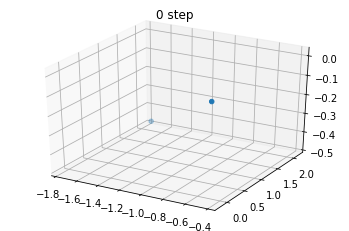

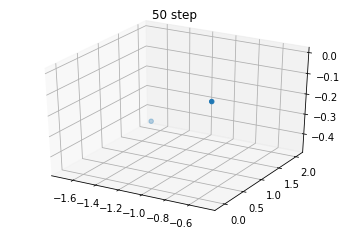

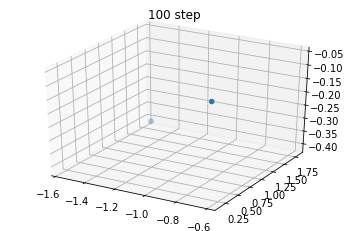

In [9]:
cm = constmass_spacemodel(dust_number=2,normalized_speed=0,mass=5,simstep=1e-2,boxlimit=100)
cm.sim(100,showflag=True,interval = 50)

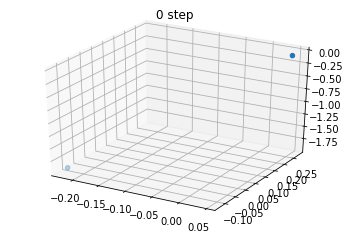

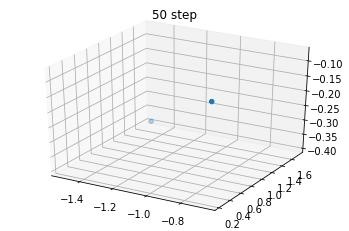

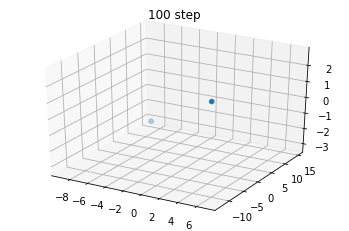

In [10]:
cm2 = constmass_spacemodel(dust_number=2,normalized_speed=0,mass=5,simstep=1e-2,boxlimit=100)
cm2.dustsvel = cm.initvel
cm2.dustspos = cm.initpos
cm2.simEuler(100,showflag=True,interval = 50)

In [148]:
g_center = np.mean(cm.dustspos,axis=0)
c_dustspos=cm.dustspos-g_center
gv_center = np.mean(cm.dustsvel,axis=0)
c_dustsvel=cm.dustsvel-gv_center

angularmoment = np.zeros((3,3))

for i in range(cm.dust_number):
    r = c_dustspos[i,:]
    v = c_dustsvel[i,:]
    angularmoment += np.outer(r,v)

In [149]:
g_icenter = np.mean(cm.initpos,axis=0)
c_idustspos=cm.initpos-g_icenter
gv_icenter = np.mean(cm.initvel,axis=0)
c_idustsvel=cm.initvel-gv_icenter

initangularmoment = np.zeros((3,3))

for i in range(cm.dust_number):
    r = c_idustspos[i,:]
    v = c_idustsvel[i,:]
    initangularmoment += np.outer(r,v)

In [150]:
print(angularmoment)
print(initangularmoment)

[[ 78797.0935229  -14732.90647783 -10019.91307381]
 [-14893.47586604 113392.80067196  19554.45316384]
 [ -9800.14440639  19407.47670938  63486.92802458]]
[[ 0.07576403  0.40855876  0.98842446]
 [ 1.15129823  0.24592677 -0.09491904]
 [-0.7012511   0.4415971  -0.18487036]]


In [151]:
cm.dust_number

100

In [130]:
np.savetxt('init.csv',cm.initpos)
np.savetxt('300step.csv',cm.dustspos)


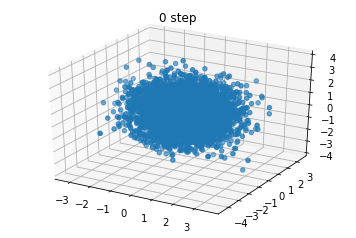

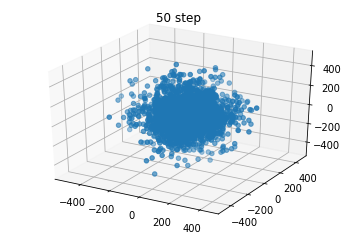

KeyboardInterrupt: 

In [132]:
cm2 = constmass_spacemodel(dust_number=5000,normalized_speed=0.5,mass=5,simstep=1e-2,boxlimit=100)
cm2.sim(300,showflag=True,interval = 50)

# plotly interactive plot

In [1]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.write_html('first_figure.html', auto_open=True)